### Načteme potřebné knihovny

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt


### a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

In [2]:
# Load the Excel file into a Pandas DataFrame
df = pd.read_excel('Projekt-2_Data.xlsx', nrows=100)

uloha_1_column = df['uloha_1 a)']

uloha_1_column

0     2
1     2
2     1
3     3
4     0
     ..
95    3
96    0
97    3
98    1
99    1
Name: uloha_1 a), Length: 100, dtype: int64

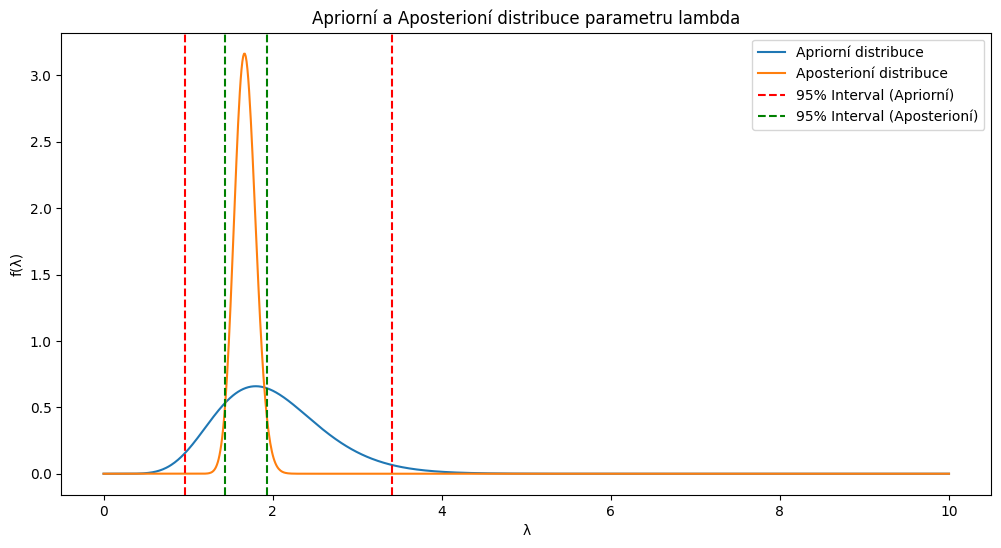

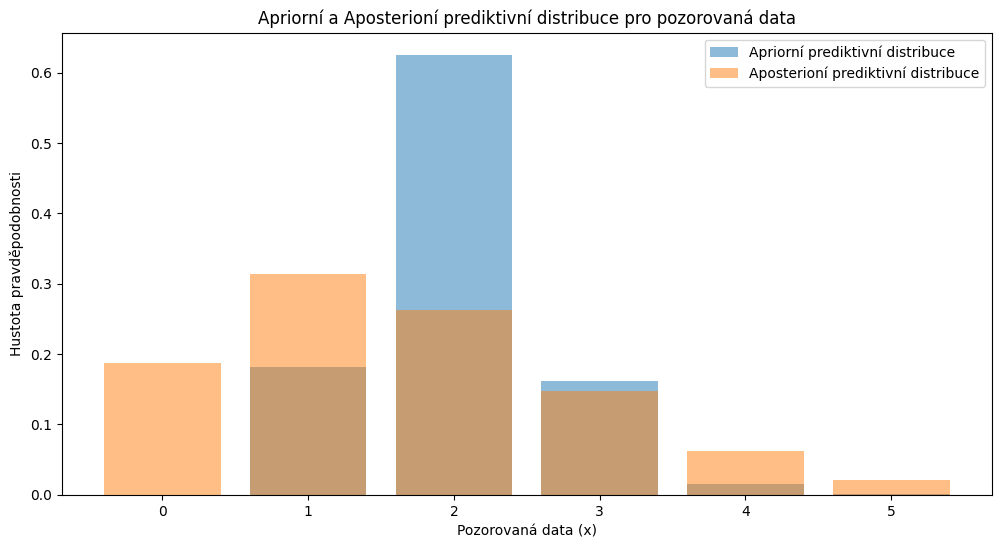

In [3]:
alpha_prior = 10

beta_prior = 5

prior_distribution = stats.gamma(alpha_prior, scale=1/beta_prior)

# Věrohodnostní funkce (Poisson)
likelihood_function = lambda x, lambda_param: stats.poisson.pmf(x, lambda_param)

# Bayesovský výpočet - Aposterioní distribuce
alpha_posterior = alpha_prior + uloha_1_column.sum() # a' = a + sum(x_i)
beta_posterior = beta_prior + len(uloha_1_column) # b' = b + n
posterior_distribution = stats.gamma(alpha_posterior, scale=1/beta_posterior)

# Výpočet kvantilů pro interval spolehlivosti
lower_bound_prior, upper_bound_prior = stats.gamma.interval(0.95, alpha_prior, scale=1/beta_prior)
lower_bound_posterior, upper_bound_posterior = stats.gamma.interval(0.95, alpha_posterior, scale=1/beta_posterior)


# Vykreslení výsledků
x_values = np.linspace(0, 10, 1000)

# Apriorní a aposteriorní distribuce parametru lambda
plt.figure(figsize=(12, 6))
plt.plot(x_values, prior_distribution.pdf(x_values), label='Apriorní distribuce')
plt.plot(x_values, posterior_distribution.pdf(x_values), label='Aposterioní distribuce')
plt.axvline(lower_bound_prior, linestyle='--', color='red', label='95% Interval (Apriorní)')
plt.axvline(upper_bound_prior, linestyle='--', color='red')
plt.axvline(lower_bound_posterior, linestyle='--', color='green', label='95% Interval (Aposterioní)')
plt.axvline(upper_bound_posterior, linestyle='--', color='green')
plt.title('Apriorní a Aposterioní distribuce parametru lambda')
plt.xlabel('λ')
plt.ylabel('f(λ)')
plt.legend()
plt.show()

# Apriorní a aposteriorní prediktivní distribuce pro pozorovaná data
plt.figure(figsize=(12, 6))
x_values_data = np.arange(0, max(uloha_1_column) + 1)
plt.bar(x_values_data, prior_distribution.pdf(x_values_data), alpha=0.5, label='Apriorní prediktivní distribuce')
plt.bar(x_values_data, likelihood_function(x_values_data, alpha_posterior/beta_posterior), alpha=0.5, label='Aposterioní prediktivní distribuce')
plt.title('Apriorní a Aposterioní prediktivní distribuce pro pozorovaná data')
plt.xlabel('Pozorovaná data (x)')
plt.ylabel('Hustota pravděpodobnosti')
plt.legend()
plt.show()


In [4]:
lower_bound_prior, upper_bound_prior = stats.gamma.interval(0.95, alpha_prior, scale=1/beta_prior)
lower_bound_posterior, upper_bound_posterior = stats.gamma.interval(0.95, alpha_posterior, scale=1/beta_posterior)

print(f"95% Interval spolehlivosti (Apriorní): ({lower_bound_prior}, {upper_bound_prior})")
print(f"95% Interval spolehlivosti (Aposterioní): ({lower_bound_posterior}, {upper_bound_posterior})\n")

mean_posterior = alpha_posterior / beta_posterior
median_posterior = (alpha_posterior - 1/3) / beta_posterior

print("Aposterioní bodové odhady parametru 𝜆:")
print(f"Střední hodnota: {mean_posterior}")
print(f"Medián: {median_posterior}")

# Bodové odhady počtu pozorovaní
mean_prior_observed = alpha_prior / beta_prior
mean_posterior_observed = alpha_posterior / beta_posterior

print("\nApriorní a aposterioní bodové odhady počtu pozorovaní:")
print(f"Apriorní střední hodnota: {mean_prior_observed}")
print(f"Aposterioní střední hodnota: {mean_posterior_observed}")

95% Interval spolehlivosti (Apriorní): (0.9590777392264868, 3.416960690283833)
95% Interval spolehlivosti (Aposterioní): (1.4376938284869922, 1.9327207471868797)

Aposterioní bodové odhady parametru 𝜆:
Střední hodnota: 1.6761904761904762
Medián: 1.6730158730158728

Apriorní a aposterioní bodové odhady počtu pozorovaní:
Apriorní střední hodnota: 2.0
Aposterioní střední hodnota: 1.6761904761904762


### b) Aproximace diskrétním rozdělením

### Věrohodnostní funkce

In [5]:
df = pd.read_excel('Projekt-2_Data.xlsx')

mean_value = 3
std_value = 1
a_value = 1

def calculate_cdf(b, mean, std):
    return stats.norm.cdf(b, loc=mean, scale=std) - stats.norm.cdf(a_value, loc=mean, scale=std)

def normal_dist(x , mean , sd):
    prob_density = (1/(np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

max_indices = df.groupby('skupina')['uloha_1 b)_prior'].idxmax()

# Select the corresponding rows from the original DataFrame
result_df = df.loc[max_indices]

b = np.linspace(min(result_df["uloha_1 b)_prior"]), max(result_df["uloha_1 b)_prior"]), 50)

observed_data = df['uloha_1 b)_pozorování'].head(100)

filtered_b = [value for value in b if all(a_value < i < value for i in observed_data)]

prob_density = []


for value in filtered_b:
    denominator = calculate_cdf(value, mean_value, std_value)
    # násobení 1/std_value je zbytečné, protože 1/1 = 1
    sum_prob = 1
    for i in observed_data:
        sum_prob *= (normal_dist(i, mean_value, std_value) / denominator)
    prob_density.append(sum_prob)
    


sum_prob_density = sum(prob_density)
verohodnostni_funkce = [x / sum_prob_density for x in prob_density]

### Apriorní rozdělení

In [6]:
b = result_df["uloha_1 b)_prior"]

hist, bin_edges = np.histogram(b, bins=50, density=True)

# Normalizace histogramu
bin_widths = np.diff(bin_edges)
normalized_hist = hist * bin_widths

# Diskrétní apriorní rozdělení
b_values = (bin_edges[:-1] + bin_edges[1:]) / 2  # Středy intervalů
apriorni_rozdeleni = normalized_hist / sum(normalized_hist)

### Aposteriorní rozdělení

In [7]:
prior_probs = apriorni_rozdeleni[-22:]
density_probs = prob_density

# Věrohodnostní funkce P(X | theta) -
likelihood = density_probs

# Bayesova věta
numerator = likelihood * prior_probs
aposteriorni_rozdeleni  = numerator / np.sum(numerator)

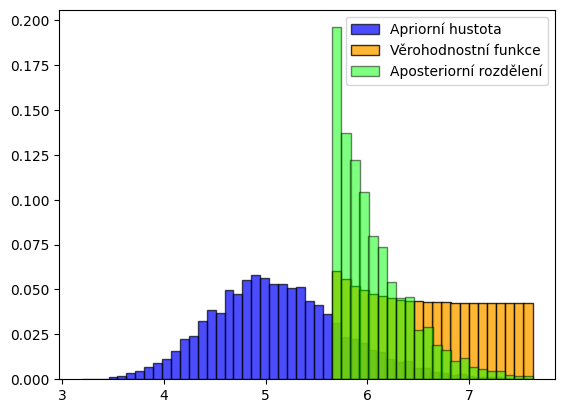

In [8]:
plt.bar(b_values, apriorni_rozdeleni, width=bin_widths, color='blue', alpha=0.7, label='Apriorní hustota', edgecolor='black')
plt.bar(filtered_b, verohodnostni_funkce, width=0.092, color='orange', alpha=0.8, label='Věrohodnostní funkce', edgecolor='black')
plt.bar(filtered_b, aposteriorni_rozdeleni, width=0.092, color='lime', alpha=0.5, label='Aposteriorní rozdělení', edgecolor='black')
plt.legend()
plt.show()

In [9]:
cumulative_posterior = np.cumsum(aposteriorni_rozdeleni)

lower = np.argmax(cumulative_posterior >= 0.025)
upper = np.argmax(cumulative_posterior >= 0.975)

lower_bound_posterior = filtered_b[lower]
upper_bound_posterior = filtered_b[upper]

print(f"95% interval spolehlivosti: ({lower_bound_posterior}, {upper_bound_posterior})")

95% interval spolehlivosti: (5.6999748786593525, 7.042014266583222)


In [10]:
expected_value = np.sum(aposteriorni_rozdeleni * filtered_b)

modus = np.argmax(aposteriorni_rozdeleni)
map_value = filtered_b[modus]

print(f"Odhad střední hodnoty: {expected_value}")
print(f"Odhad modu: {map_value}")

Odhad střední hodnoty: 6.067086994212372
Odhad modu: 5.6999748786593525


### Úloha 2

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 2')


data.rename(columns={'Ping [ms]': 'Ping'}, inplace=True)

data_encoded = pd.get_dummies(data, columns=['OSType'], drop_first=True, dtype=int)


# Aktualizovaný vzorec s konkrétními koeficienty

formula = "Ping ~ ActiveUsers + ScrollingPct + OSType_MacOS + OSType_Windows + OSType_iOS + I(ActiveUsers ** 2) + ActiveUsers*ScrollingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows + ActiveUsers*OSType_iOS"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.69e-190
Time:                        18:39:45   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [12]:
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

# Indexy největších Cookových vzdáleností
outliers_index = np.where(cooks_distance > 4 / data.shape[0])[0]

data.iloc[outliers_index]

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
12,Windows,8990,0.9812,0.0188,55
35,iOS,9313,0.9674,0.0326,45
41,Android,1538,0.2466,0.7534,13
54,iOS,7957,0.0242,0.9758,35
113,iOS,2356,0.9780,0.0220,36
144,iOS,9516,0.5413,0.4587,60
145,Android,3421,0.8852,0.1148,37
166,iOS,2835,0.9138,0.0862,56
178,Windows,1207,0.0766,0.9234,33
255,Windows,5513,0.4912,0.5088,90


In [13]:
# Odstranění extrémně odlehlých hodnot
data_no_outliers = data.drop(outliers_index, axis=0)
data_no_outliers

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


In [14]:
# Identifikace nejproblematičtějších hodnot
problematic_values = data.loc[outliers_index, ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'OSType', 'Ping [ms]']]
print("Nejproblematičtější hodnoty:")
print(problematic_values)

KeyError: "['Ping [ms]'] not in index"

In [ ]:
# Příklad s uživatelem s Windows
user_windows = {'ActiveUsers': data['ActiveUsers'].mean(),
                'InteractingPct': data['InteractingPct'].mean(),
                'ScrollingPct': data['ScrollingPct'].mean(),
                'OSType': 'Windows'}

predicted_ping = model.predict(pd.DataFrame(user_windows, index=[0]))

ci = model.get_prediction(pd.DataFrame(user_windows, index=[0])).conf_int()
# Konfidenční a predikční intervaly
ci_df = pd.DataFrame(ci, columns=['lower', 'upper'])

# Konfidenční a predikční intervaly
pred_int_df = model.get_prediction(pd.DataFrame(user_windows, index=[0])).conf_int(obs=True)
print("Odhadnutá hodnota odezvy:", predicted_ping[0])
print("Konfidenční interval:", ci_df.iloc[0])
print("Predikční interval:", pred_int_df[0])


Odhadnutá hodnota odezvy: 52.295432410093895
Konfidenční interval: lower    51.066410
upper    53.524455
Name: 0, dtype: float64
Predikční interval: [39.56633982 65.024525  ]
